In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Step 2: Load the dataset
df = pd.read_csv("Book Reviews.csv")

# Step 3: Show first few rows
df.head()


,Unnamed: 0,Book,Review,Review Date
0,0,To Kill a Mockingbird,/// gentle reminder that this is not the time ...,"March 24, 2022"
1,1,To Kill a Mockingbird,\n|\n|6.0 stars. I know I am risking a serious...,"May 24, 2011"
2,2,To Kill a Mockingbird,\n|\n|Looking for a new book but don't want to...,"December 10, 2020"
3,3,To Kill a Mockingbird,"To Kill a Mockingbird, Harper Lee|To Kill a Mo...","July 1, 2022"
4,4,To Kill a Mockingbird,Why is it when I pick up | To Kill A Mockingbi...,"October 25, 2009"


In [5]:
# Step 4: Clean the text a bit
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = text.replace('\n', ' ')
    text = text.replace('|', ' ')
    text = text.replace('///', ' ')
    return text.strip()

# Apply cleaning
df['cleaned_review'] = df['Review'].apply(clean_text)

# Show cleaned reviews
df[['Review', 'cleaned_review']].head()


,Review,cleaned_review
0,/// gentle reminder that this is not the time ...,gentle reminder that this is not the time to r...
1,\n|\n|6.0 stars. I know I am risking a serious...,6.0 stars. I know I am risking a serious “FILM...
2,\n|\n|Looking for a new book but don't want to...,Looking for a new book but don't want to commi...
3,"To Kill a Mockingbird, Harper Lee|To Kill a Mo...","To Kill a Mockingbird, Harper Lee To Kill a Mo..."
4,Why is it when I pick up | To Kill A Mockingbi...,Why is it when I pick up To Kill A Mockingbi...


In [8]:
# Step 5: VADER sentiment scoring on small batch to test speed
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize analyzer
sia = SentimentIntensityAnalyzer()

# Use only first 500 rows to avoid freezing
sample_df = df.head(500).copy()

# Score each review
sample_df['vader_score'] = sample_df['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Map score to label
def get_vibe(score):
    if score >= 0.4:
        return 'positive'
    elif score <= -0.4:
        return 'negative'
    else:
        return 'neutral'

sample_df['sentiment'] = sample_df['vader_score'].apply(get_vibe)

# Show results
sample_df[['cleaned_review', 'vader_score', 'sentiment']].head()


[nltk_data] Downloading package vader_lexicon to /home/ajwa-
[nltk_data]     asghar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,cleaned_review,vader_score,sentiment
0,gentle reminder that this is not the time to r...,-0.4994,negative
1,6.0 stars. I know I am risking a serious “FILM...,0.9986,positive
2,Looking for a new book but don't want to commi...,-0.9643,negative
3,"To Kill a Mockingbird, Harper Lee To Kill a Mo...",0.3400,neutral
4,Why is it when I pick up To Kill A Mockingbi...,0.9019,positive


/tmp/ipykernel_35656/682921960.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=sample_df, palette='pastel')


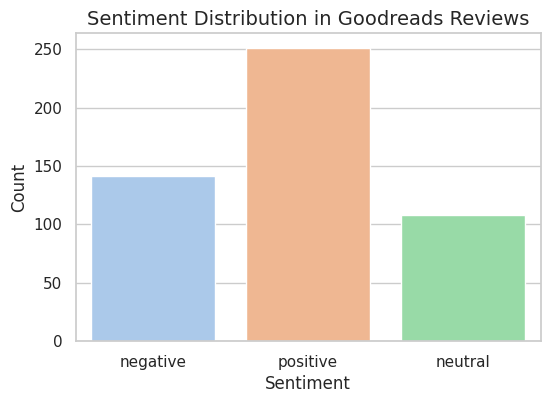

In [9]:
# Step 6: Visualize sentiment counts
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=sample_df, palette='pastel')
plt.title("Sentiment Distribution in Goodreads Reviews", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [15]:
# Step 7: Vectorize text and split data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the cleaned review text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(sample_df['cleaned_review'])

# Encode labels as 0/1/2
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = sample_df['sentiment'].map(label_map)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Step 8: Train a classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))


Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.21      0.32        28
     neutral       0.77      0.77      0.77        22
    positive       0.66      0.90      0.76        50

    accuracy                           0.68       100
   macro avg       0.68      0.63      0.62       100
weighted avg       0.67      0.68      0.64       100



In [17]:
# Step 9: Try the model on your own review!
def predict_sentiment(review_text):
    # Clean the text like before
    review_cleaned = re.sub(r'[^\w\s]', '', review_text.lower())
    # Vectorize
    review_vec = vectorizer.transform([review_cleaned])
    # Predict
    pred_label = model.predict(review_vec)[0]
    # Map number back to word
    vibe_map = {0: 'negative 💀', 1: 'neutral 😐', 2: 'positive 🌞'}
    return vibe_map[pred_label]

# Try it!
test_review = "I just finished this book and omg I feel like I've been emotionally destroyed but in a good way."
print("Vibe:", predict_sentiment(test_review))


Vibe: positive 🌞


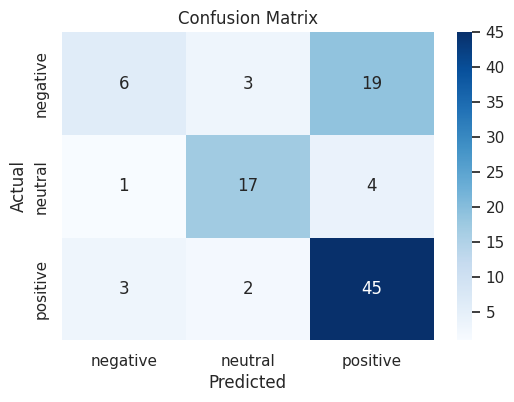

In [18]:
# Step 10: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("Book Reviews.csv")


df['cleaned_review'] = df['Review'].astype(str).str.replace(r'\n|\r|\||\\', ' ', regex=True).str.lower()
df = df.dropna(subset=['cleaned_review'])


In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Get VADER score
df['vader_score'] = df['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Map score to sentiment label
def get_vibe(score):
    if score >= 0.4:
        return 'positive'
    elif score <= -0.4:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['vader_score'].apply(get_vibe)


[nltk_data] Downloading package vader_lexicon to /home/ajwa-
[nltk_data]     asghar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
# Vectorize and split
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


VECTRORIZE AND SPLIT

In [ ]:

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Evaluate Accuracy & Classification Report

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on test set
y_pred = model.predict(X_test)

# Print Accuracy
print(f"🔍 Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Print detailed classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))


🔍 Accuracy: 0.78

📋 Classification Report:

              precision    recall  f1-score   support

    negative       0.75      0.61      0.67      1454
     neutral       0.78      0.71      0.74      1700
    positive       0.80      0.90      0.85      3263

    accuracy                           0.78      6417
   macro avg       0.78      0.74      0.75      6417
weighted avg       0.78      0.78      0.78      6417



Plot Confusion Matrix (Heatmap)

/tmp/ipykernel_39110/282435162.py:13: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ajwa-asghar/Documents/sentiment analysis/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


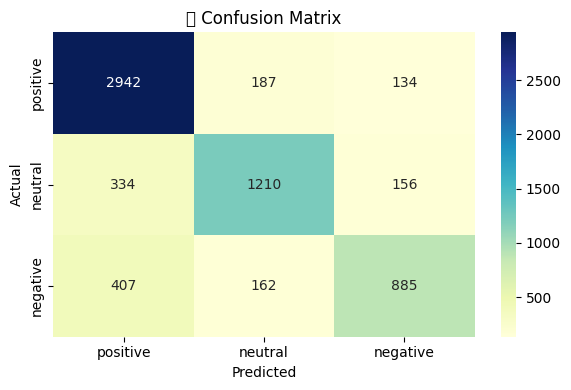

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])

# Plot as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('💥 Confusion Matrix')
plt.tight_layout()
plt.show()
